In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Seg3D/KiTS2019/kits19

/content/drive/MyDrive/Seg3D/KiTS2019/kits19


In [3]:
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /tmp/pip-req-build-_p67n249
  Running command git clone --filter=blob:none --quiet https://github.com/shijianjian/EfficientNet-PyTorch-3D /tmp/pip-req-build-_p67n249
  Resolved https://github.com/shijianjian/EfficientNet-PyTorch-3D to commit c13e36455573a55dea2ae4d5d09c85e01e654a7d
  Preparing metadata (setup.py) ... done


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  2 10:06:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import glob

preds = glob.glob("/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/predictions/*")
len(preds)


90

In [ ]:
random_choice = np.random.choice(preds)
random_msk = np.load(random_choice)

print("random_choice:", random_choice)
print("value:", np.unique(random_msk))
print("shape:", random_msk.shape)

random_choice: /content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/predictions/prediction_00280.nii.gz.npy
value: [0 1 2]
shape: (80, 160, 160)


random_pos: 15


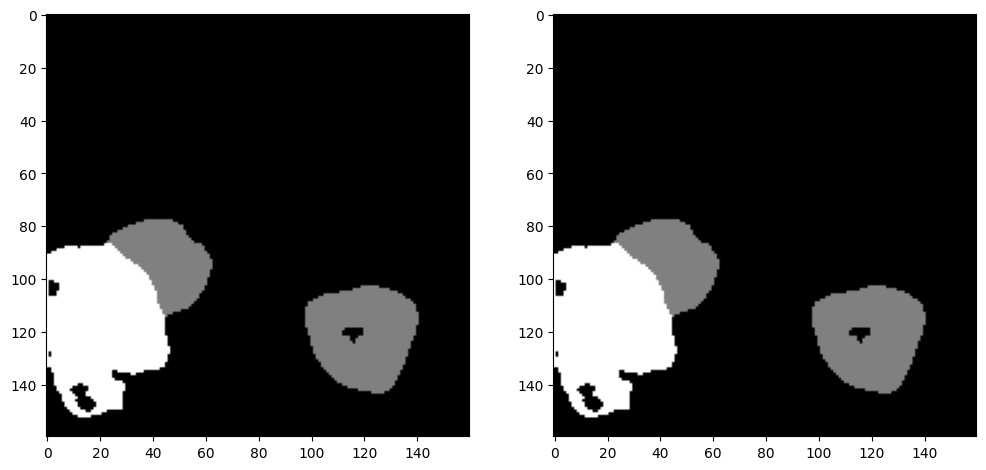

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12, 8))
random_pos = np.random.choice(np.where(random_msk.sum(axis=(1,2)) > 3)[0])
print("random_pos:", random_pos)

axes[0].imshow(random_msk[random_pos], cmap=plt.cm.gray)
axes[1].imshow(random_msk[random_pos], cmap=plt.cm.gray)


In [ ]:
import numpy as np 
import nibabel as nib
from scipy.ndimage.interpolation import zoom

from segment.data.augs import aug_maps

def resample(v, dxyz, new_dxyz, order=1):
    dz, dy, dx = dxyz[:3]
    new_dz, new_dy, new_dx = new_dxyz[:3]

    z, y, x = v.shape

    new_x = np.round(x * dx / new_dx)
    new_y = np.round(y * dy / new_dy)
    new_z = np.round(z * dz / new_dz)

    new_v = zoom(v, (new_z / z, new_y / y, new_x / x), order=order)
    return new_v

def create_one_item(item):
    pred_path = item["npy_seg_path"]
    preprocess_vol_path = item["new_vol_path"]
    vol_path = item["vol_path"]
    case_id = item["case_id"]

    vol = nib.load(vol_path)
    vol_affine = vol.affine[[2,1,0,3]]
    vol_array = vol.get_fdata()

    preprocess_vol_arr = np.load(preprocess_vol_path)
    seg_array = np.load(pred_path)
    print("-" * 10, seg_array.shape)        
    seg_array = aug_maps["crop_and_pad_if_needed"](seg_array, axes=(0,1,2), crop_size=preprocess_vol_arr.shape)
    print("*" * 10, seg_array.shape)        
    seg_array = resample(seg_array, [3, 1.5, 1.5], np.diag(abs(vol_affine)), order=0)
    print("=" * 10, seg_array.shape)        
    seg_array = aug_maps["crop_and_pad_if_needed"](seg_array, axes=(0,1,2), crop_size=vol_array.shape)
    print("+" * 10, seg_array.shape) 
    seg_nii = nib.Nifti1Image(seg_array, affine=vol.affine)
    return seg_nii


<ipython-input-10-dc12def2328f>:3: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [ ]:
item = {
    "case_id": "case_00213",
    "vol_path": "/content/drive/MyDrive/Seg3D/KiTS2019/kits19/data/case_00213/imaging.nii.gz",
    "new_vol_path": "/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/test_data/vol/case_00213_imaging.nii.gz.npy",
    "npy_seg_path": "/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/predictions/prediction_00213.nii.gz.npy",
    "nii_seg_path": "predictions/prediction_00213.nii.gz"
}


In [ ]:
nii_item = create_one_item(item=item)


**Prepare test data**

In [9]:
from segment.inference.prepare_test_data import prepare_test_data

In [ ]:
# prepare_test_data(
#         data_path = "/content/drive/MyDrive/Seg3D/KiTS2019/kits19/data/",
#         config_path = "/content/drive/MyDrive/Seg3D/KiTS2019/kits19/configs/preprocess_pipeline.yaml",
#         vol_path = "/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/test_data/vol",
#         out_path = "/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/test_data.json"
# )


**Inference**

In [10]:
from segment.inference.infer_pipeline import inference

In [11]:
inference(
        data_path="/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/test_data_cp.json", 
        out_path="/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/predictions",
        pred_path="/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/predictions.json",
        model_name_or_path="UnetRes_v2",
        config_path="/content/drive/MyDrive/Seg3D/KiTS2019/kits19/configs/preprocess_pipeline.yaml",
        pretrained_path="/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/models/best_model_2703_softmax.pt",
        freeze_feature=False,  
        num_classes=3,
        act_func="softmax"
)


<All keys matched successfully>
pretrained_path: /content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/models/best_model_2703_softmax.pt
num param: 91734833


inference :   0%|          | 0/5 [00:00<?, ?it/s]

test data shape: torch.Size([1, 1, 80, 160, 160])


0it [00:00, ?it/s]

postprocessing :   0%|          | 0/5 [00:00<?, ?it/s]

INFO:segment.utils.file_utils:The number of test dataset is 5
INFO:segment.utils.file_utils:Saved test dataset at /content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/predictions


Convert to Nii

In [ ]:
import numpy as np 
import nibabel as nib
import glob

from segment.utils.file_utils import read_yaml_file, load_json_file

configs = read_yaml_file("/content/drive/MyDrive/Seg3D/KiTS2019/kits19/configs/preprocess_pipeline.yaml")["preprocess"]
test_data = load_json_file("/content/drive/MyDrive/Seg3D/KiTS2019/kits19/output/predictions.json")["data"]

idc=1
test_data[idc]


In [ ]:
print(nib.load(test_data[idc]["nii_seg_path"]))

In [ ]:
print(nib.load(test_data[idc]["vol_path"]))

In [ ]:
index = np.random.choice(len(test_data))
print(index)
print(test_data[index])

vol_nii = nib.load(test_data[index]["vol_path"])
vol_array = vol_nii.get_fdata()
vol_array = np.clip(vol_array, configs["lower_bound"], configs["upper_bound"])

pred_nii = nib.load(test_data[index]["nii_seg_path"])
pred_array = pred_nii.get_fdata()
print(np.unique(pred_array))

assert vol_array.shape == pred_array.shape, f"{vol_array.shape} {pred_array.shape}" 

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,8))

ax1.imshow(vol_array[pred_array.shape[0]//2])

ax2.imshow(vol_array[pred_array.shape[0]//2])
ax2.imshow(pred_array[pred_array.shape[0]//2], alpha=0.6)

ax3.imshow(pred_array[pred_array.shape[0]//2])
